In [1]:
import pandas as pd
import numpy as np
import pycountry as pyc
import re
import pycountry_convert as pycon
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Add Granularity:

In [2]:
data = pd.read_csv('Michelin_Details_2019.csv', index_col = 0)
data.head(5)

,name,address,min_price,max_price,currency,cuisine,description,star,comfort,delightful,services,phone,website,hours,lat,lon,url
0,Shin Sushi,"16573 Ventura Blvd., Encino, 91436, United States",50.0,75.0,USD,Japanese,"Set in a nondescript shopping center, this hig...",1.0,2.0,0.0,"['New establishment in the guide', 'Establishm...",+1 818-616-4148,Not Available,Dinner Tue - Sat,34.157840,-118.494150,https://guide.michelin.com/en/california/encin...
1,Hayato,"1320 E. 7th St., Ste. 126, Los Angeles, 90001,...",75.0,150.0,USD,Japanese,The entrance can be a bit tricky to locate wit...,1.0,3.0,0.0,"['New establishment in the guide', 'Establishm...",+1 213-395-0607,www.hayatorestaurant.com,Dinner Tue - Sat,34.033110,-118.242650,https://guide.michelin.com/en/california/us-lo...
2,Angler,"132 The Embarcadero, San Francisco, 94101, Uni...",75.0,150.0,USD,Contemporary,Pitched as a more casual counterpart to the st...,1.0,3.0,0.0,"['Notable cocktail list', 'Wheelchair accessib...",+1 415-872-9442,www.anglerrestaurants.com,Lunch Thu - Sat Dinner nightly,37.793167,-122.392130,https://guide.michelin.com/en/california/san-f...
3,Harbor House,"5600 CA-1, Elk, United States",75.0,150.0,USD,Californian,You’ll drive along winding roads past sloping ...,1.0,3.0,1.0,"['Notable wine list', 'New establishment in th...",+1 800-720-7474,www.theharborhouseinn.com,Dinner Thu - Mon,39.135876,-123.719444,https://guide.michelin.com/en/california/elk/r...
4,Addison,"5200 Grand Del Mar Way, San Diego, 92130, Unit...",75.0,150.0,USD,Contemporary,"Among other luxuries, an evening at the Addiso...",1.0,5.0,0.0,"['Notable cocktail list', 'Wheelchair accessib...",+1 858-314-1900,www.addisondelmar.com,Dinner Tue - Sat,32.939903,-117.200130,https://guide.michelin.com/en/california/us-sa...


### Add Country & Continent:

In [3]:
addresses = [item.split(',') for item in data.address]
country = [item[-1].strip() for item in addresses]
data['country'] = country

In [4]:
def replace_country(text):
    text = re.sub('South Korea', 'Korea, Republic of', text)
    text = re.sub('Republic of Ireland', 'Ireland', text)
    
    return text

In [5]:
data['country'] = data['country'].apply(lambda x: replace_country(x))
data['country_alpha2'] = data['country'].apply(lambda x: pyc.countries.lookup(x).alpha_2)
data['continent_code'] = data['country_alpha2'].apply(lambda x: pycon.country_alpha2_to_continent_code(x))

# Convert Currencies:

In [6]:
currency_url = 'https://www.x-rates.com/table/?from=USD&amount=1'
currency_page = requests.get(currency_url)
currency_soup = BeautifulSoup(currency_page.content, 'html.parser')

In [7]:
currency_table = currency_soup.find_all(class_ = 'tablesorter ratesTable')

In [8]:
home = []
foreign = []
value = []
for item in currency_table[0].find_all('a'):
    link = item['href']
    home.append(re.findall(r'=(.*)&', link)[0])
    foreign.append(re.findall(r'to=(.*)', link)[0])
    value.append(item.contents[0])

In [9]:
converter = pd.DataFrame([home, foreign, value]).T
converter.columns = ['from', 'to', 'conversion_rate']
converter.head(5)

,from,to,conversion_rate
0,USD,ARS,64.324985
1,ARS,USD,0.015546
2,USD,AUD,1.622127
3,AUD,USD,0.616474
4,USD,BHD,0.376000


In [10]:
converted_price = []
for index, row in data.iterrows():
    conversion = row.currency
    if conversion == 'USD':
        converted_price.append((row.min_price, row.max_price))
    else:
        rate_table = converter[converter['from'] == conversion]
        rate = rate_table['conversion_rate']
        try:
            rate = float(rate.values[0])
            converted_price.append((round(row.min_price * rate, 2), round(row.max_price * rate, 2)))
        except:
            converted_price.append((0, 0))

In [11]:
data['USD_min_price'] = [item[0] for item in converted_price]
data['USD_max_price'] = [item[1] for item in converted_price]

In [12]:
data[['min_price', 'USD_min_price', 'currency']]

,min_price,USD_min_price,currency
0,50.0,50.00,USD
1,75.0,75.00,USD
2,75.0,75.00,USD
3,75.0,75.00,USD
4,75.0,75.00,USD
...,...,...,...
2614,20.0,14.01,SGD
2615,50.0,35.03,SGD
2616,48.0,33.63,SGD
2617,88.0,61.65,SGD


# Clean & Aggregate Cuisine:

In [13]:
data['cuisine'] = data['cuisine'].apply(lambda x: x.upper().strip())
data['aggregate_cuisine'] = data['cuisine'].copy()

In [14]:
set(data['cuisine'])

{'AMERICAN',
 'APULIAN',
 'ASIAN',
 'ASIAN CONTEMPORARY',
 'ASIAN INFLUENCES',
 'AUSTRALIAN CONTEMPORARY',
 'AUSTRIAN',
 'BARBECUE',
 'BASQUE CONTEMPORARY',
 'BEIJING-CANTONESE',
 'BRITISH CONTEMPORARY',
 'CALIFORNIAN',
 'CAMPANIAN',
 'CANTONESE',
 'CANTONESE ROAST MEATS',
 'CANTONESE-SICHUAN',
 'CHINESE',
 'CLASSIC CUISINE',
 'CLASSIC FRENCH',
 'CONTEMPORARY',
 'CORSICAN',
 'COUNTRY COOKING',
 'CREATIVE',
 'CREATIVE BRITISH',
 'CREATIVE FRENCH',
 'CUISINE FROM ABRUZZO',
 'DANISH',
 'DIM SUM',
 'EMILIAN',
 'EUROPEAN',
 'EUROPEAN CONTEMPORARY',
 'FRENCH',
 'FRENCH CONTEMPORARY',
 'FUJIAN',
 'FUSION',
 'GALICIAN',
 'GASTROPUB',
 'GREEK',
 'HANG ZHOU',
 'HOME COOKING',
 'HUNANESE AND SICHUAN',
 'INDIAN',
 'INNOVATIVE',
 'INTERNATIONAL',
 'ISRAELI',
 'ITALIAN',
 'ITALIAN CONTEMPORARY',
 'JAPANESE',
 'JAPANESE CONTEMPORARY',
 'KOREAN',
 'KOREAN CONTEMPORARY',
 'LYONNAISE',
 'MANTUAN',
 'MARKET CUISINE',
 'MEATS AND GRILLS',
 'MEDITERRANEAN',
 'MEDITERRANEAN CUISINE',
 'MEXICAN',
 'MIDDLE EA

In [15]:
def aggregating_cuisines(text):
    
    text = re.sub(r'STREET FOOD|PERANAKAN|ASIAN INFLUENCES', 'ASIAN', text)
    text = re.sub('CLASSIC CUISINE', 'CLASSIC', text)
    text = re.sub('MODERN CUISINE', 'MODERN', text)
    text = re.sub(r'INTERNATIONAL|WORLD CUISINE', 'FUSION', text)
    text = re.sub(r'TRADITIONAL BRITISH|GASTROPUB', 'BRITISH', text)
    text = re.sub('CANTONESE-SICHUAN', 'CANTONESE', text)
    
    text = re.sub('VEGAN','VEGETARIAN', text)    
    text = re.sub(r'SUSHI|TEPPANYAKI', 'JAPANESE', text)
    text = re.sub(r'BASQUE|GALICIAN', 'SPANISH', text)
    text = re.sub(r'FUJIAN|HANG ZHOU|HUNANESE AND SICHUAN|SHANGHAINESE|SICHUAN-HUAI YANG|TAIWANESE|TAIZHOU|ZHEJIANG', 'CHINESE', text)
    text = re.sub(r'SICHUAN', 'CHINESE', text)
    text = re.sub(r'TEOCHEW|DIM SUM|BEIJING-CANTONESE|CANTONESE ROAST MEATS|NOODLES AND CONGEE',  'CANTONESE', text)
    text = re.sub(r'APULIAN|CAMPANIAN|CUISINE FROM ABRUZZO|EMILIAN|MANTUAN|PIEDMONTESE|TUSCAN', 'ITALIAN', text)
    text = re.sub(r'CORSICAN|LYONNAISE|CLASSIC FRENCH|PROVENÇAL', 'FRENCH', text)
    
    text = re.sub(r'CREATIVE ', '', text)
    text = re.sub(r' CUISINE', '', text)
    text = re.sub(r'MODERN ', '', text)
    text = re.sub(r' CONTEMPORARY', '', text)
    
    #The following are below threshold of 1% of total entries and will be combined:
    text = re.sub(r'AUSTRIAN|SCOTTISH|ISRAELI|HOME COOKING', 'EUROPEAN', text)
    text = re.sub('BARBECUE', 'JAPANESE', text) #this is Japanese BBQ in Taiwan
    text = re.sub(r'MOROCCAN|GREEK', 'MEDITERRANEAN', text)
    text = re.sub('MEATS AND GRILLS', 'FRENCH', text) #this restaurant serves French-style meats
    text = re.sub(r'DANISH', 'SCANDINAVIAN', text)
    
    
    return text


In [16]:
data[data['cuisine'] == 'STREET FOOD']

,name,address,min_price,max_price,currency,cuisine,description,star,comfort,delightful,...,hours,lat,lon,url,country,country_alpha2,continent_code,USD_min_price,USD_max_price,aggregate_cuisine
2588,Hawker Chan,"335 Smith Street #02-126, Singapore",3.0,15.0,SGD,STREET FOOD,"Formerly known as ""Liao Fan Hong Kong Soya Sau...",1.0,99.0,0.0,...,"OPENING HOURS, LAST ORDER: 10:00-17:00 (17:00)",1.28248,103.8439,https://guide.michelin.com/en/singapore-region...,Singapore,SG,AS,2.1,10.51,STREET FOOD
2589,Hill Street Tai Hwa Pork Noodle,"Blk 466, #01-12, Crawford Lane, Singapore",5.0,10.0,SGD,STREET FOOD,"Using fresh ingredients, the noodles are cooke...",1.0,99.0,0.0,...,"OPENING HOURS, LAST ORDER: Lunch: 09:30-21:00 ...",1.30520,103.8624,https://guide.michelin.com/en/singapore-region...,Singapore,SG,AS,3.5,7.01,STREET FOOD


In [17]:
data['aggregate_cuisine'] = data['cuisine'].apply(lambda x: aggregating_cuisines(x))

In [18]:
print(len(set(data['aggregate_cuisine'])))
set(data['aggregate_cuisine'])

33


{'AMERICAN',
 'ASIAN',
 'AUSTRALIAN',
 'BRITISH',
 'CALIFORNIAN',
 'CANTONESE',
 'CHINESE',
 'CLASSIC',
 'CONTEMPORARY',
 'COUNTRY COOKING',
 'CREATIVE',
 'EUROPEAN',
 'FRENCH',
 'FUSION',
 'INDIAN',
 'INNOVATIVE',
 'ITALIAN',
 'JAPANESE',
 'KOREAN',
 'MARKET',
 'MEDITERRANEAN',
 'MEXICAN',
 'MIDDLE EASTERN',
 'MODERN',
 'ORGANIC',
 'REGIONAL',
 'SCANDINAVIAN',
 'SEAFOOD',
 'SPANISH',
 'STEAKHOUSE',
 'THAI',
 'TRADITIONAL',
 'VEGETARIAN'}

In [19]:
# Visualize distribution of cuisines:
pd.set_option('display.max_rows', 100)

groupby_cuisine = data.groupby('aggregate_cuisine').count()['name']
proportion = groupby_cuisine / data.shape[0]
proportion.sort_values()


aggregate_cuisine
AUSTRALIAN         0.000382
MIDDLE EASTERN     0.000382
ORGANIC            0.001145
VEGETARIAN         0.002291
STEAKHOUSE         0.002291
SCANDINAVIAN       0.002673
SPANISH            0.003055
MEXICAN            0.003055
AMERICAN           0.003818
INDIAN             0.004200
COUNTRY COOKING    0.004582
FUSION             0.004582
CALIFORNIAN        0.004964
REGIONAL           0.004964
EUROPEAN           0.005727
MARKET             0.006109
KOREAN             0.006491
ASIAN              0.007255
THAI               0.008400
CHINESE            0.008782
TRADITIONAL        0.009927
INNOVATIVE         0.011837
SEAFOOD            0.016800
MEDITERRANEAN      0.017182
CANTONESE          0.018709
BRITISH            0.021000
ITALIAN            0.025582
CONTEMPORARY       0.034746
JAPANESE           0.038564
CLASSIC            0.042383
FRENCH             0.104238
CREATIVE           0.243986
MODERN             0.329897
Name: name, dtype: float64

In [20]:
regularized = proportion[proportion > .01]

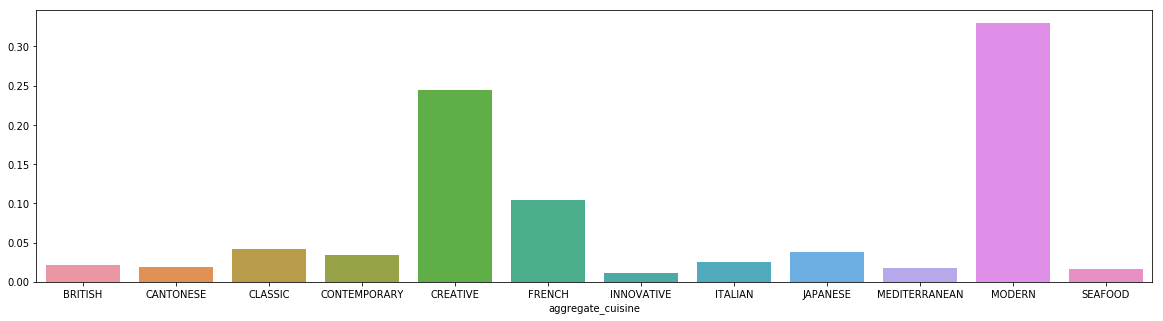

In [21]:
f, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=regularized.index, y= regularized.values, ax = ax)



In [22]:
data.shape

(2619, 23)

In [23]:
data.to_csv('Michelin_Details.csv')